# Predicting the take time for shipping food delivery

In [ ]:
import sys
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt


from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM

import pickle


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.feature_engineer import vincenty_distance, bearing_degree
from src.feature_selection import (
    create_plot_correlation,
    rfe_feature_selection,
    feature_importance,
)
from src.metrics import metrics_values

In [3]:
path = os.path.join("..", "data", "food_delivery.csv")
df = pd.read_csv(path, sep=";")
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30


In [4]:
df["vincenty_distance"] = df.apply(
    lambda row: vincenty_distance(
        row["Restaurant_latitude"],
        row["Restaurant_longitude"],
        row["Delivery_location_latitude"],
        row["Delivery_location_longitude"],
    ),
    axis=1,
)

In [5]:
df["bearing_distance"] = df.apply(
    lambda row: bearing_degree(
        row["Restaurant_latitude"],
        row["Restaurant_longitude"],
        row["Delivery_location_latitude"],
        row["Delivery_location_longitude"],
    ),
    axis=1,
)

In [6]:
# Type_of_order

dic_name = {
    "Snack ": 1,
    "Drinks ": 2,
    "Buffet ": 3,
    "Meal ": 4,
    # Type_of_vehicle
    "motorcycle ": 1,
    "scooter ": 2,
    "electric_scooter ": 3,
    "bicycle ": 4,
}


df = df.replace(dic_name)

/tmp/ipykernel_1760597/4052078066.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(dic_name)


In [7]:
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min),vincenty_distance,bearing_distance
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,1,1,24,3.015007,42.677357
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,1,2,33,20.115858,44.244219
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,2,1,26,1.547552,44.264436
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,3,1,21,7.764282,44.461223
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,1,2,30,6.189317,44.252603


### Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(
        columns=[
            "Time_taken(min)",
            "ID",
            "Delivery_person_ID",
            "Restaurant_latitude",
            "Restaurant_longitude",
            "Delivery_location_latitude",
            "Delivery_location_longitude",
        ]
    ),
    df["Time_taken(min)"],
    test_size=0.25,
    random_state=42,
)

### Feature Selection

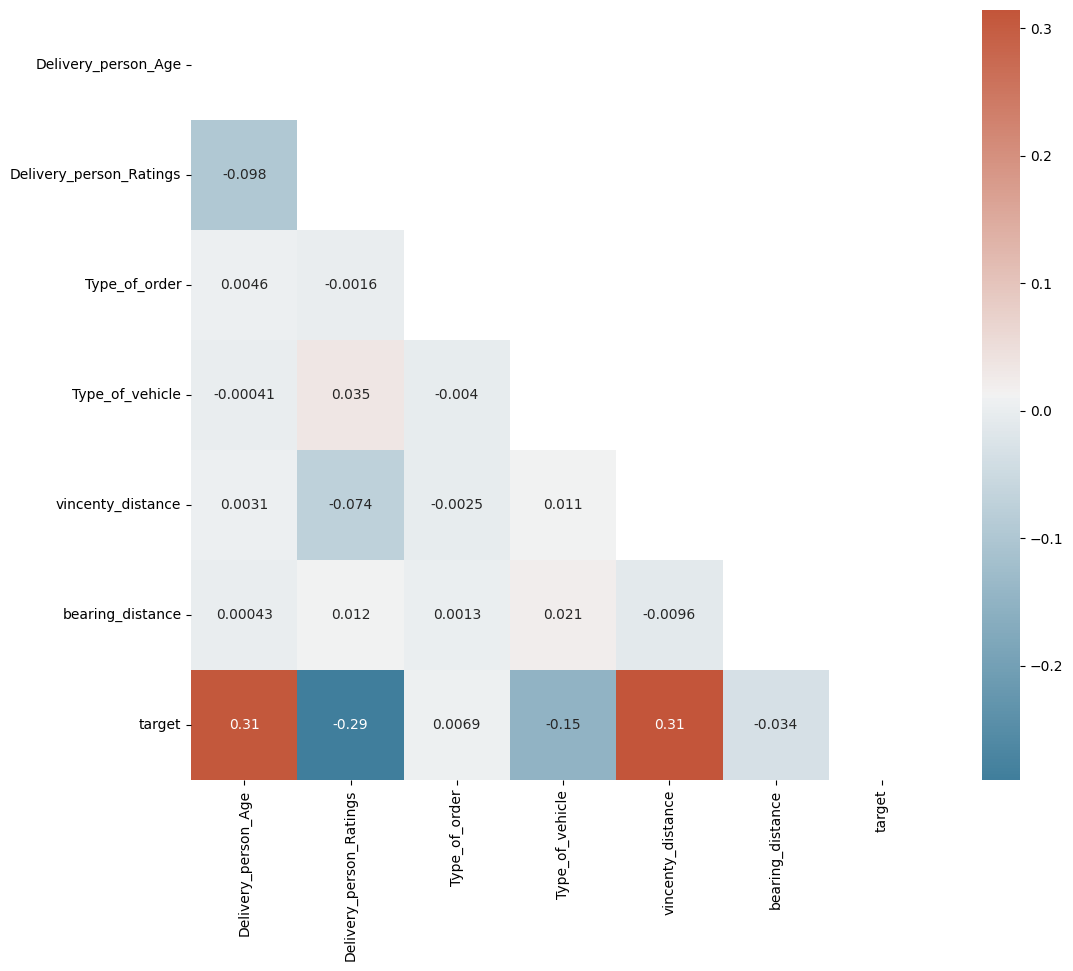

In [9]:
create_plot_correlation(X_train, y_train, "spearman")

Mean Squared Error: 70.0797121287864


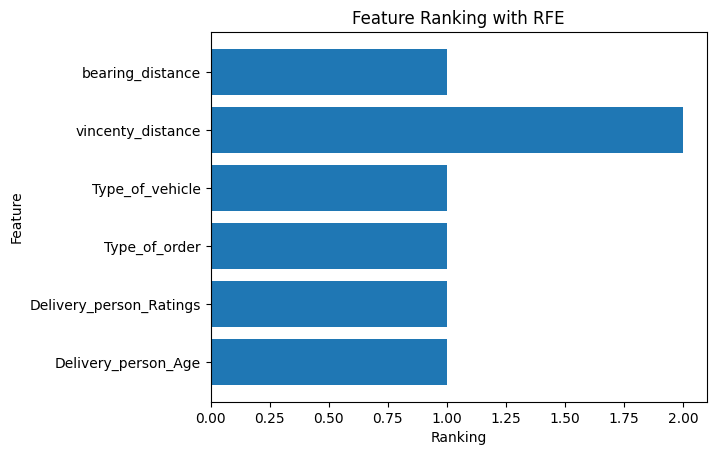

In [10]:
rfe_columns = rfe_feature_selection(X_train, y_train, "LinearRegression", 5)

Feature: Delivery_person_Age, Score:0.16961
Feature: Delivery_person_Ratings, Score:0.26474
Feature: Type_of_order, Score:0.06013
Feature: Type_of_vehicle, Score:0.03782
Feature: vincenty_distance, Score:0.28939
Feature: bearing_distance, Score:0.17831


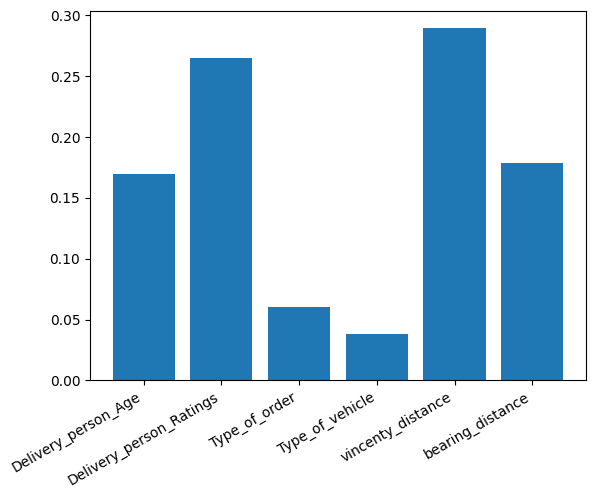

In [11]:
feature_importance(X_train, y_train, "RandomForestRegressor")

Feature: Delivery_person_Age, Score:0.14691999554634094
Feature: Delivery_person_Ratings, Score:0.4296799898147583
Feature: Type_of_order, Score:0.03237999975681305
Feature: Type_of_vehicle, Score:0.14384999871253967
Feature: vincenty_distance, Score:0.21186000108718872
Feature: bearing_distance, Score:0.03531000018119812


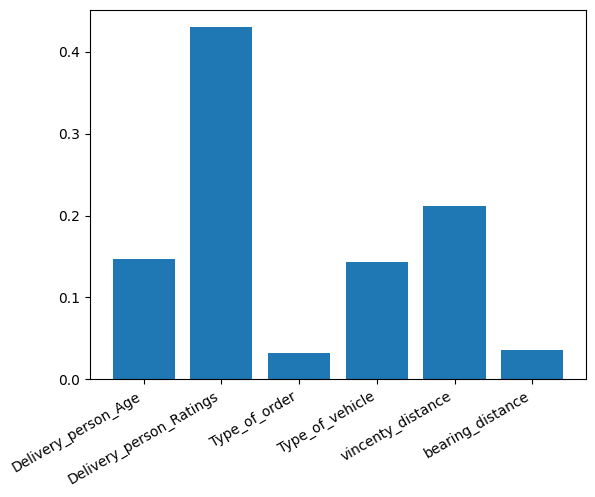

In [13]:
feature_importance(X_train, y_train, "XGboost")

Training Model

In [14]:
feature_used = [
    "Delivery_person_Age",
    "Delivery_person_Ratings",
    "Type_of_vehicle",
    "vincenty_distance",
    "bearing_distance",
]

### Train models

In [ ]:
model_gbost = XGBRegressor()
model_gbost.fit(X_train[feature_used], y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


: 

: 

: 

: 

: 

In [ ]:
model = Sequential()
model.add(
    LSTM(
        128,
        return_sequences=True,
        input_shape=(np.array(X_train[feature_used]).shape[1], 1),
    )
)
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

E0000 00:00:1756066713.649782 1665332 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1756066713.657811 1665332 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/plagueis/Documents/new/pproject/food_delivery_prediction_regression_20240211/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

: 

: 

: 

: 

: 

In [ ]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(np.array(X_train[feature_used]), np.array(y_train), batch_size=1, epochs=6)

Epoch 1/6
34194/34194 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 70.8054
Epoch 2/6
34194/34194 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 61.1143
Epoch 3/6
34194/34194 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - loss: 59.0945
Epoch 4/6
34194/34194 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - loss: 57.8935
Epoch 5/6
34194/34194 ━━━━━━━━━━━━━━━━━━━━ 103s 3ms/step - loss: 57.5440
Epoch 6/6
34194/34194 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - loss: 57.7861


: 

: 

: 

: 

: 

### Evaluation models

In [16]:
predict_xgbost = model_gbost.predict(X_test[feature_used])

In [19]:
predict_lstm = model.predict(np.array(X_test[feature_used]))

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [20]:
table = pd.DataFrame(
    {
        "y_test": y_test,
        "predict_xgbost": predict_xgbost,
        "predict_lstm": [element[0] for element in predict_lstm],
    }
).reset_index(drop=True)
table

,y_test,predict_xgbost,predict_lstm
0,44,33.480042,29.320892
1,41,30.685728,30.284056
2,39,34.380413,35.557751
3,38,34.037251,32.382362
4,38,26.145216,27.275677
...,...,...,...
11394,29,19.526772,19.488405
11395,42,36.891129,36.645313
11396,24,19.299515,21.320690
11397,41,38.518028,34.190868


In [21]:
result_xgbost = metrics_values(table["y_test"], table["predict_xgbost"])

Mean Absolute Error (MAE): 5.75899600982666
Mean Squared Error (MSE): 53.837100982666016
Root Mean Squared Error (RMSE): 2898.433442217778
Mean Squared Logarithmic Error (MSLE): 0.08161522448062897
Median Absolute Error (MedAE): 4.736442565917969
R-squared (R2): 0.38591665029525757
Explained Variance Score: 0.38596922159194946


In [22]:
result_lstm = metrics_values(table["y_test"], table["predict_lstm"])

Mean Absolute Error (MAE): 5.898758888244629
Mean Squared Error (MSE): 55.99205017089844
Root Mean Squared Error (RMSE): 3135.1096823404077
Mean Squared Logarithmic Error (MSLE): 0.08331867307424545
Median Absolute Error (MedAE): 4.901485443115234
R-squared (R2): 0.3613366484642029
Explained Variance Score: 0.36363691091537476


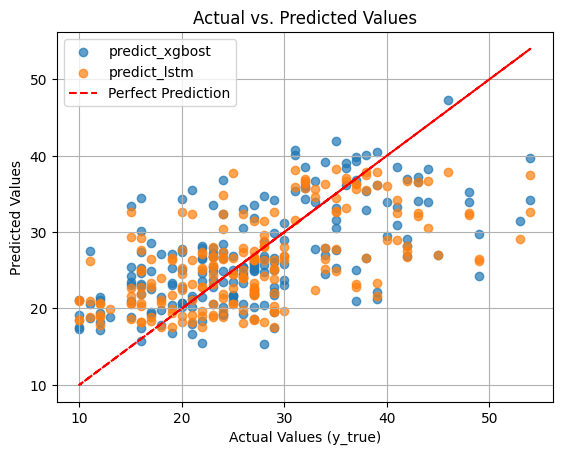

In [ ]:
plt.scatter(
    table["y_test"].tail(200),
    table["predict_xgbost"].tail(200),
    alpha=0.7,
    label="predict_xgbost",
)
plt.scatter(
    table["y_test"].tail(200),
    table["predict_lstm"].tail(200),
    alpha=0.7,
    label="predict_lstm",
)

plt.plot(
    table["y_test"].tail(200),
    table["y_test"].tail(200),
    color="red",
    linestyle="--",
    label="Perfect Prediction",
)


plt.title("Actual vs. Predicted Values")
plt.xlabel("Actual Values (y_true)")
plt.ylabel(f"Predicted Values")
plt.legend()
plt.grid(True)

plt.show()

## Save model

In [ ]:
def save_model_pickle(model, filename):
    """Save a model to disk using pickle."""
    with open(filename, "wb") as f:
        pickle.dump(model, f)
    print(f"Model saved to {filename}")


save_model_pickle(model_gbost, "../models/model_gbost.pkl")
save_model_pickle(model, "../models/model_lstm.pkl")